In [261]:
%matplotlib inline
import pandas as pd
from pandas import DataFrame
import functools
import glob, os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, precision_score
from sklearn.pipeline import Pipeline
from sklearn.externals import joblib

In [262]:
SIData_dir = '/Users/thuong/Documents/SI_Data'
df_arr = []
for f in glob.glob(os.path.join(SIData_dir, '*.csv')):
    df_arr.append(pd.read_csv(f, encoding='latin1'))
df = functools.reduce(lambda left, right: pd.merge(left, right, on=['BKG_NO']), df_arr)

In [263]:
df.replace({'#': ' '}, regex=True, inplace=True)
df.replace({'\$': ' '}, regex=True, inplace=True)
df.head(5)

,BKG_NO,ALSO_NOTIFY,CONSIGNEE,POR,POL,POD,DEL,VESSEL,MARK,DESCRIPTION,NOTIFY,SHIPPER
0,AAR402333700,,TO ORDER,AARHUS PORT,ROTTERDAM,BEIJIAO CHINA,BEIJIAO CHINA,HAMMERSMITH BRIDGE 0029E,NaN,FF WHITE FISH MEAL DANISH WHITE FISHMEAL (F...,FUZHOU PIN GUAN TRADE CO. LTD. 1720RM 17/F. ...,FF SKAGEN A/S HAVNEVAGTVEJ 5 9990 SKAGEN DE...
1,AAR402376700,,BIOSEVE 5 AVENUE LA PRINCESSE LALLA MERYEM ...,FREDERICIA,HAMBURG,CASABLANCA,CASABLANCA,HANJIN EUROPE 0013E,NaN,1195 CLL FISH FEED SHIPPED ON BOARD HANJIN ...,SAME AS CONSIGNEE,ALLER AQUA A/S ALLERVEJ 130 DK-6070 CHRISTIA...
2,AAR402394700,,TO ORDER,FREDERICIA,HAMBURG,PORT KLANG,PORT KLANG,CSCL GLOBE 0002E,NaN,"DANISH FISHMEAL ""999 PRIME QUALITY"" FREIGHT...",T.B.M. SDN.BHD. 10H-1 JALAN TUN ABDUL RAZAK ...,NORSILDMEL AS KJERREIDVIKEN 16 5141 FYLLINGS...
3,AAR402402400,* PHONE: +862258783500 FAX: +862258783555,DSV AIR & SEA CO. LTD SUITE 1402 NINGTAI PL...,FREDERICIA,HAMBURG,XINGANG,XINGANG,COSCO PORTUGAL 0003E,7566612656,WINDMILL PARTS,ALL INVOICE COPIES DSV AIR & SEA CO. LTD SU...,DSV AIR & SEA A/S I101 NOKIAVEJ 30 8700 HORS...
4,AAR402395100,** TEL.: (886) 2 2507 7071 EXT. 223,TO ORDER,AARHUS,HAMBURG,KAOHSIUNG,KAOHSIUNG,HUMEN BRIDGE 0047E,NaN,810 BAGS DANISH FISHMEAL 999-LT SHIPPED ON...,CHAROEN POKPHAND ENTERPRISE (TAIWAN) CO. LTD....,NORSILDMEL AS KJERREIDVIKEN 16 5141 FYLLINGS...


In [264]:
from sklearn.feature_extraction import text
stop_words = set(text.ENGLISH_STOP_WORDS)

In [265]:
def text_cleaning(text):
    words = []
    words.extend(w for w in str(text).split() 
                    if w.isalpha() and len(w) != 1 and w.lower() != 'nan' 
                                    and w.lower() not in stop_words)
    return ' '.join(words)

In [266]:
df_data = DataFrame(columns=['Value', 'Class'])
class_names = []
for col in df:
    if col != 'BKG_NO':
        df[col] = df[col].apply(text_cleaning)
        tmp_df = DataFrame(columns=['Value', 'Class'])
        tmp_df['Value'] = df[col]
        tmp_df['Class'] = col
        df_data = df_data.append(tmp_df)
        class_names.append(col)
    else:
        df[col] = df[col]
df_data = df_data[df_data['Value'] != ""]
df_data = df_data.reset_index(drop=True)

In [267]:
df_data = df_data.reindex(np.random.permutation(df_data.index))

In [268]:
TRAIN_SIZE = 0.8
size = int(len(df_data) * TRAIN_SIZE)
df_train, df_test = df_data.iloc[:size], df_data.iloc[size:]

In [269]:
total_amount = [len(df_data[df_data['Class'] == c]) for c in class_names]
train_amount = [len(df_train[df_train['Class'] == c]) for c in class_names]
test_amount = [len(df_test[df_test['Class'] == c]) for c in class_names]
tmp_arr = np.array([total_amount, train_amount, test_amount])
print(DataFrame(tmp_arr, ['Total', 'Train', 'Test'], class_names))

       ALSO_NOTIFY  CONSIGNEE     POR     POL     POD     DEL  VESSEL   MARK  \
Total        25312     102672  102232  102388  100899  100900  102737  44181   
Train        20292      82272   81773   81949   80448   80697   82368  35301   
Test          5020      20400   20459   20439   20451   20203   20369   8880   

       DESCRIPTION  NOTIFY  SHIPPER  
Total       102645  101428   102731  
Train        82155   81121    82124  
Test         20490   20307    20607  


In [270]:
pipeline = Pipeline([
                    ('vectorizer', CountVectorizer()),
                    ('tfidf_transformer',  TfidfTransformer()),
                    ('classifier', LinearSVC())])

train_data, test_data = df_train['Value'].values, df_test['Value'].values
train_target, test_target = df_train['Class'].values, df_test['Class'].values

pipeline.fit(train_data, train_target)
predictions = pipeline.predict(test_data)

cnf_matrix = confusion_matrix(test_target, predictions)
print('Confusion matrix with one-fold: ')
print(cnf_matrix)
print("Score with one-fold: %s" % precision_score(test_target, predictions, average = 'weighted'))
print("Score with one-fold: %s" % precision_score(test_target, predictions, average = None))

Confusion matrix with one-fold: 
[[ 4091   244    41    14    75   271    84    29    23   140     8]
 [   76 14492    11    15    95  4754     6     1     1   940     9]
 [   38    13  5121     2    12     4 11329  1947  1724    11     2]
 [   25    15     2 20291   128    12     1     0     2    14     0]
 [  187   228    40   258  7777   129   124    23    15    89    10]
 [  198  6472    20    17    78 12778    10     0     5   727     2]
 [   25     1  2377     1    10     2 14010  3743   279     1     2]
 [    3     0    62     0     3     1  1249 17178  1940     3     0]
 [   43     5   357     2     4     9   998  9620  9397    22     2]
 [   52   527    22    16    35   263     3     5    12 19667     5]
 [   27     2     6     0     1     1    20     3     2     2 20305]]
Score with one-fold: 0.748393140901
Score with one-fold: [ 0.85855194  0.65875722  0.63543864  0.98423555  0.94633731  0.7011633
  0.50334124  0.52775815  0.70126866  0.90983531  0.99803391]


In [271]:
new_df = df_data
new_df["SentenceLength"] = new_df['Value'].apply(lambda x: len(x.split()))

In [272]:
print("Max value's length: %s" % max(new_df["SentenceLength"]))
print("Min value's length: %s" % min(new_df["SentenceLength"]))

Max value's length: 355
Min value's length: 1


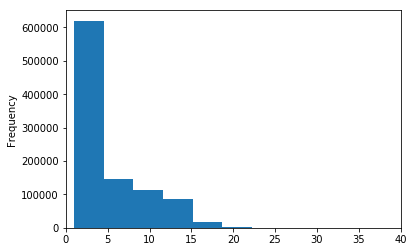

In [283]:
new_df["SentenceLength"].plot.hist(bins=100, xlim=(0, 40))

(array([  0.00000000e+00,   0.00000000e+00,   2.04946000e+05,
          0.00000000e+00,   2.68968000e+05,   0.00000000e+00,
          1.16088000e+05,   0.00000000e+00,   3.02540000e+04,
          0.00000000e+00,   2.74170000e+04,   0.00000000e+00,
          3.58990000e+04,   0.00000000e+00,   3.98040000e+04,
          0.00000000e+00,   4.18880000e+04,   0.00000000e+00,
          4.33430000e+04,   0.00000000e+00,   3.70010000e+04,
          0.00000000e+00,   3.40410000e+04,   0.00000000e+00,
          2.91940000e+04,   0.00000000e+00,   2.38360000e+04,
          0.00000000e+00,   1.87410000e+04,   0.00000000e+00,
          1.47490000e+04,   0.00000000e+00,   9.25900000e+03,
          0.00000000e+00,   6.01200000e+03,   0.00000000e+00,
          3.40000000e+03,   0.00000000e+00,   1.70700000e+03,
          0.00000000e+00,   8.73000000e+02,   0.00000000e+00,
          4.15000000e+02,   0.00000000e+00,   1.80000000e+02,
          0.00000000e+00,   4.20000000e+01,   0.00000000e+00,
        

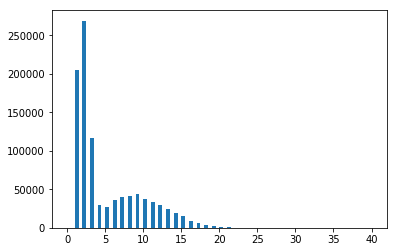

In [282]:
plt.hist(new_df["SentenceLength"], bins=80, range=(0, 40))
# plt.xticks(ind, keys, rotation=45)
# plt.ylabel('Missing Values')
# plt.title('Number of missing values in SI documents')